In [30]:
# Imports
import time
import pydotplus
import graphviz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

from IPython.display import Image
%matplotlib inline

# Surpress warnings
import warnings
warnings.filterwarnings("ignore")

# Pandas options set-up
pd.set_option("display.max_columns", 50)

## Boxing data
Can we predict the outcome of a boxing match?

In [2]:
bouts = pd.read_csv("bouts_out_new.csv")
bouts.head()

,age_A,age_B,height_A,height_B,reach_A,reach_B,stance_A,stance_B,weight_A,weight_B,won_A,won_B,lost_A,lost_B,drawn_A,drawn_B,kos_A,kos_B,result,decision,judge1_A,judge1_B,judge2_A,judge2_B,judge3_A,judge3_B
0,35.0,27.0,179.0,175.0,178.0,179.0,orthodox,orthodox,160.0,160.0,37,49,0,1,0,1,33,34.0,draw,SD,110.0,118.0,115.0,113.0,114.0,114.0
1,26.0,31.0,175.0,185.0,179.0,185.0,orthodox,orthodox,164.0,164.0,48,50,1,2,1,1,34,32.0,win_A,UD,120.0,108.0,120.0,108.0,120.0,108.0
2,28.0,26.0,176.0,175.0,NaN,179.0,orthodox,orthodox,154.0,154.0,23,47,0,1,1,1,13,33.0,win_B,KO,NaN,NaN,NaN,NaN,NaN,NaN
3,25.0,29.0,175.0,174.0,179.0,180.0,orthodox,orthodox,155.0,155.0,46,31,1,3,1,0,32,19.0,win_A,KO,47.0,48.0,49.0,46.0,48.0,47.0
4,25.0,35.0,175.0,170.0,179.0,170.0,orthodox,orthodox,155.0,NaN,45,40,1,4,1,0,32,33.0,win_A,UD,118.0,110.0,119.0,109.0,117.0,111.0


In [3]:
# Transform the dataset from rows of bouts to rows of boxers
# Split the dataframe into two subset dataframes (boxer A and boxer B)

# Dataframe for boxer A
bouts_A = bouts[["age_A", "height_A", "reach_A", "stance_A", "weight_A",
                 "won_A", "lost_A", "drawn_A", "kos_A", "result", "decision",
                "judge1_A", "judge2_A", "judge3_A"]]

# Dataframe for boxer B
bouts_B = bouts[["age_B", "height_B", "reach_B", "stance_B", "weight_B",
                 "won_B", "lost_B", "drawn_B", "kos_B", "result", "decision",
                "judge1_B", "judge2_B", "judge3_B"]]

# Rename the columns for each of the subset dataframes to remove the A/B distinction,
# allowing them to be concatenated together.
combined_col_names = ['age', 'height', 'reach', 'stance', 'weight', 'won', 'lost', 'drawn',
                      'kos', 'result', 'decision','judge1', 'judge2', 'judge3']

bouts_A.columns = combined_col_names
bouts_B.columns = combined_col_names

# Replace result with a variable that gives the bout outcome from the prospective individual boxer (A or B)
# Change to binary outcome to support classification: 1 for win, 0 for did not win (loss and draw)
# Create result list for boxer A
result_list_A = []
for result in bouts_A["result"]:
    if result == "win_A":
        result_list_A.append(1)
    else:
        result_list_A.append(0)
    
#Replace result column with data from the new result_list
bouts_A["result"] = result_list_A

# Create result list for boxer B
result_list_B = []
for result in bouts_B["result"]:
    if result == "win_B":
        result_list_B.append(1)
    else:
        result_list_B.append(0)
        
#Replace result column with data from the new result_list
bouts_B["result"] = result_list_B
    

# Concatente the the two subset dataframes into one combined dataframe
mega_bouts = pd.concat([bouts_A, bouts_B])

# Reset the index
mega_bouts = mega_bouts.reset_index(drop=True)

mega_bouts.head()

,age,height,reach,stance,weight,won,lost,drawn,kos,result,decision,judge1,judge2,judge3
0,35.0,179.0,178.0,orthodox,160.0,37,0,0,33.0,0,SD,110.0,115.0,114.0
1,26.0,175.0,179.0,orthodox,164.0,48,1,1,34.0,1,UD,120.0,120.0,120.0
2,28.0,176.0,NaN,orthodox,154.0,23,0,1,13.0,0,KO,NaN,NaN,NaN
3,25.0,175.0,179.0,orthodox,155.0,46,1,1,32.0,1,KO,47.0,49.0,48.0
4,25.0,175.0,179.0,orthodox,155.0,45,1,1,32.0,1,UD,118.0,119.0,117.0


Drop judge scoring and decision type, as they will not be needed for the prediction model.

In [4]:
mega_bouts.drop(["decision", "judge1", "judge2", "judge3"], axis=1, inplace=True)
mega_bouts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774854 entries, 0 to 774853
Data columns (total 10 columns):
age       610823 non-null float64
height    383886 non-null float64
reach     150215 non-null float64
stance    462018 non-null object
weight    265931 non-null float64
won       774854 non-null int64
lost      774854 non-null int64
drawn     774854 non-null int64
kos       774775 non-null float64
result    774854 non-null int64
dtypes: float64(5), int64(4), object(1)
memory usage: 59.1+ MB


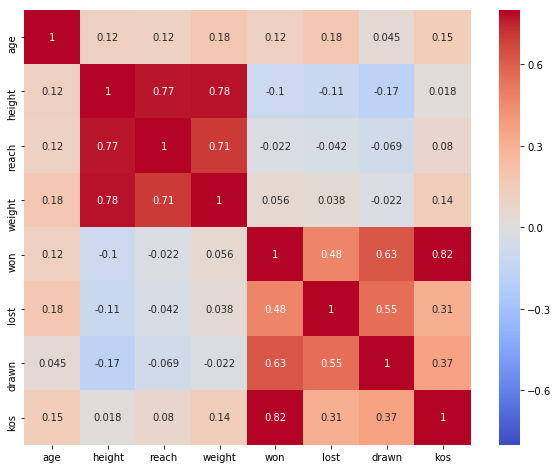

In [5]:
corr_mat = mega_bouts.drop("result", axis=1).corr()
fig = plt.figure(figsize=(10, 8))
sns.heatmap(data=corr_mat, vmin=-0.8, vmax=0.8, annot=True, cmap="coolwarm")
plt.show()

There are some troublesome correlations that we will deal with below.

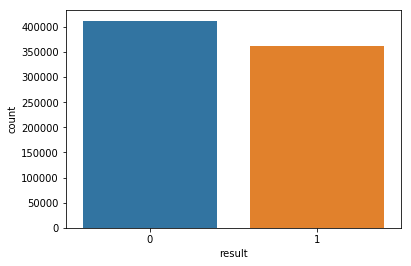

In [6]:
sns.countplot(x="result", data=mega_bouts)
plt.show()

Result will be the target variable. At this point the data is balanced between the outcomes.

In [7]:
# Build some features for height/weight and wins/kos (which are highly correlated)
mega_bouts["height_x_weight"] = mega_bouts["height"] * mega_bouts["weight"]
mega_bouts["wins_x_kos"] = mega_bouts["won"] * mega_bouts["kos"]

# Create dummy variable for stance
mega_bouts = pd.get_dummies(mega_bouts, drop_first=True)

mega_bouts.head()

,age,height,reach,weight,won,lost,drawn,kos,result,height_x_weight,wins_x_kos,stance_southpaw
0,35.0,179.0,178.0,160.0,37,0,0,33.0,0,28640.0,1221.0,0
1,26.0,175.0,179.0,164.0,48,1,1,34.0,1,28700.0,1632.0,0
2,28.0,176.0,NaN,154.0,23,0,1,13.0,0,27104.0,299.0,0
3,25.0,175.0,179.0,155.0,46,1,1,32.0,1,27125.0,1472.0,0
4,25.0,175.0,179.0,155.0,45,1,1,32.0,1,27125.0,1440.0,0


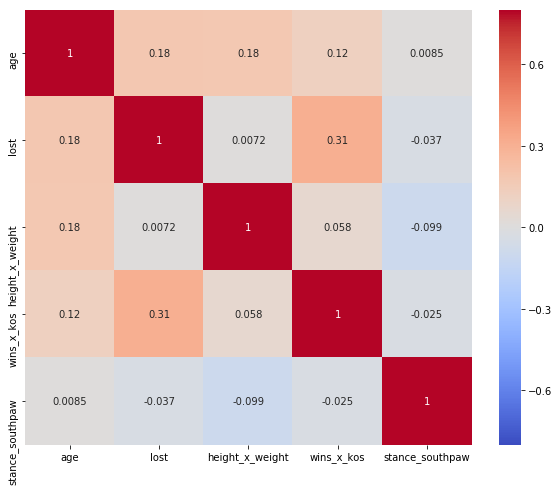

In [8]:
corr_mat = mega_bouts.drop(["height", "weight", "reach", "won", "drawn", "kos", "result"], axis=1).corr()
fig = plt.figure(figsize=(10, 8))
sns.heatmap(data=corr_mat, vmin=-0.8, vmax=0.8, annot=True, cmap="coolwarm")
plt.show()

This looks better.

In [9]:
# Remove observations with non-sensical data for age, height, weight, and reach.
mega_bouts = mega_bouts[(mega_bouts["age"] >= 15)]
mega_bouts = mega_bouts[(mega_bouts["age"] <= 60)]
mega_bouts = mega_bouts[(mega_bouts["height"] >= 147)]
mega_bouts = mega_bouts[(mega_bouts["height"] <= 224)]
mega_bouts = mega_bouts[(mega_bouts["weight"] >= 77)]
mega_bouts = mega_bouts[(mega_bouts["weight"] <= 350)]

print(mega_bouts.shape)
mega_bouts.describe().transpose()

(149304, 12)


,count,mean,std,min,25%,50%,75%,max
age,149304.0,25.594813,5.129630,15.0,22.0,25.0,29.0,59.0
height,149304.0,173.553180,8.929097,147.0,168.0,173.0,180.0,218.0
reach,66703.0,179.536483,12.537736,1.0,172.0,178.0,185.0,456.0
weight,149304.0,149.133781,32.419490,77.0,126.0,141.0,163.0,350.0
won,149304.0,24.525090,27.669509,0.0,6.0,16.0,32.0,262.0
lost,149304.0,6.929272,11.653969,0.0,0.0,3.0,9.0,263.0
drawn,149304.0,2.233684,4.635388,0.0,0.0,1.0,2.0,61.0
kos,149304.0,11.898315,12.977924,0.0,3.0,8.0,17.0,131.0
result,149304.0,0.611651,0.487376,0.0,0.0,1.0,1.0,1.0
height_x_weight,149304.0,26117.453377,6966.806675,12782.0,21120.0,24505.0,29192.0,70929.0


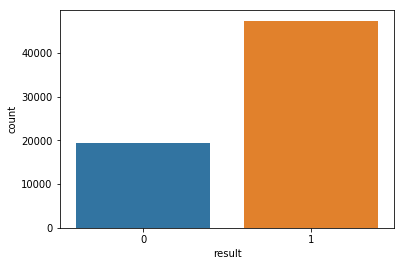

In [10]:
sns.countplot(x="result", data=mega_bouts.dropna())
plt.show()

In [11]:
mega_bouts["result"].value_counts(normalize=True)

1    0.611651
0    0.388349
Name: result, dtype: float64

We lost some of the balance in the target variable while cleaning the data, which could be a problem as decision trees are sensitive to the dominant class.

We note that the number to beat for an accuracy score is 0.611651.

In [35]:
features = mega_bouts[["age", "height_x_weight", "lost", "wins_x_kos", "stance_southpaw"]]
target = mega_bouts["result"]

## Decision Tree

In [36]:
pipe_dec = Pipeline([("scl", StandardScaler()),
                ("dec_tree", DecisionTreeClassifier(criterion="entropy", max_features=1, max_depth=4))])

In [37]:
start_time = time.time()
scores = cross_val_score(pipe_dec, features, target, cv=10)
end_time = time.time()
print("\n--- {:.5f} seconds ---".format(end_time - start_time))


--- 0.91964 seconds ---


In [38]:
print(scores)
print("CV accuracy: {:.3f} +\- {:.3f}".format(np.mean(scores), np.std(scores)))

[0.63394053 0.53890972 0.68794374 0.66543871 0.6600134  0.60133958
 0.67916946 0.59430676 0.61245814 0.61326189]
CV accuracy: 0.629 +\- 0.043


In [48]:
X = np.array(features)
y = np.array(target)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [50]:
param_grid = [{"dec_tree__criterion": ["entropy", "gini"],
               "dec_tree__max_features": [1, 2, 3],
               "dec_tree__max_depth": [1, 2, 3, 4, 5, 6, 7, None]}]
gs = GridSearchCV(estimator=pipe_dec,
                 param_grid=param_grid,
                 scoring="accuracy",
                 cv=10,
                 n_jobs=-1)

In [51]:
start_time = time.time()
gs.fit(X_train, y_train)
#print(cross_val_score(gs, features, target, cv=10))
end_time = time.time()
print("\n--- {:.5f} seconds ---".format(end_time - start_time))


--- 34.45712 seconds ---


In [52]:
gs.best_score_

0.7123900102977989

In [53]:
gs.best_params_

{'dec_tree__criterion': 'gini',
 'dec_tree__max_depth': 7,
 'dec_tree__max_features': 3}

In [55]:
dec_tree = gs.best_estimator_

start_time = time.time()
scores = cross_val_score(dec_tree, features, target, cv=10)
end_time = time.time()
print("\n--- {:.5f} seconds ---".format(end_time - start_time))

print()
print(scores)
print("\nCV accuracy: {:.3f} +\- {:.3f}".format(np.mean(scores), np.std(scores)))


--- 1.88795 seconds ---

[0.66776051 0.59643718 0.68379102 0.68204956 0.82250502 0.76892163
 0.71426658 0.65860683 0.67856664 0.65780308]

CV accuracy: 0.693 +\- 0.060


In [56]:
#decision_tree = DecisionTreeClassifier(criterion="entropy", max_features=1, max_depth=4)
#decision_tree.fit(features, target)

#start_time = time.time()
#print(cross_val_score(decision_tree, features, target, cv=10))
#end_time = time.time()
#print("\n--- {:.5f} seconds ---".format(end_time - start_time))

This looks overfit and model often failed to improve on the null accuracy rate of 0.611651.

## Random Forest

In [58]:
#rfc = ensemble.RandomForestClassifier()
#start_time = time.time()
#print(cross_val_score(rfc, features, target, cv=10))
#end_time = time.time()
#print("\n--- {:.5f} seconds ---".format(end_time - start_time))

Still overfit, but maybe less so than the Decision Tree model. Again, however, the model is worse than the null accuracy rate.